In [5]:
import numpy as np

N = 20000
t = np.linspace(0,10,N)
dt = t[1] - t[0]
N_state = 5
N_output = 1
N_input = 1

## System parameter
ep = 0.037
epsilon = 0.0001
beta = 42
J_O2 = 6e-3
phi_in_O2 = 0.21
phi_in_H2 = 0.99
E0_cell = 1.2271
B_conc = 0.05
T_fc = 320.
A_fc = 0.1
rho0 = 0.006
rhoj = 4e-5
rhoT = 5e-5
V_act0 = 0.0178
C_DL = 4.8
z = 4
F = 96485.33
L = 5.9435e-5
L = 0.0013144869567532369
D = 2.2e-5

tau0 = 4*L**2/(D*np.pi)
tau1 = 4*L**2/(9*D*np.pi)
#tau0 = 0.1
#tau1 = 0.1/9
R = 8.3145

x = np.zeros([N_state,1,N])


#x0 = [0.21;0.21;0;0;0];
x[:,:,0] = np.array([0.201,0.251,0.10,0.0,0.0]).reshape(-1,1)


r = np.zeros([N_output,1,N])
rdot = np.zeros([N_output,1,N])
rddot = np.zeros([N_output,1,N])
y = np.zeros([N_output,1,N])

u = np.zeros([N_input,1,N])
e = np.zeros([N_input,1,N])
int_e = np.zeros([N_input,1,N])
dif_e = np.zeros([N_input,1,N])
u_eq = np.zeros([N_input,1,N])
u_S = np.zeros([N_input,1,N])
v_eq = np.zeros([N_input,1,N])
v_S = np.zeros([N_input,1,N])
s = np.zeros([N_input,1,N])
s2 = np.zeros([N_input,1,N])
#u_eq[0,0,0] = 100.
#u[0,0,0] = 10.

##
omega=2*np.pi*1
J_ss = 1000
J_amp = J_ss/2


### Controller Parametter
q = 5
p = 3
kd = 10.
kp = 1000.
ki = 800.
alpha = 0.9
b = 5.
m1 = 10.
m2 = 20.
delta = 1.
l = 0.0025

## Observer parameter
x_obs = np.zeros([N_state,1,N])
x_bar = np.zeros([N_state,1,N])
P_obs = np.random.rand(N_state,N_state,N)
#x_obs[:,:,0] = np.array([0.201,0.251,0.10,0.0,0.0]).reshape(-1,1)
Q_obs = np.array([[0.000001]])
R_obs = np.array([[0.05]])
y_obs = np.zeros([N_output,1,N])


i = 0
u[0,0,i] = 0.1

#def main(param):
#kp,kd,ki,b,m1,m2,delta = param
for i in range(N-1):


        #u[0,0,i]=(J_ss+J_amp*np.sin(omega*t[i]))
        #r[0,0,i] = 0.95 + 0.05*np.sin(t[i])+0.02*np.sin(3*t[i])
        r[0,0,i] = + 5.*np.cos(t[i])+ 3.*np.sin(3*t[i])
        rdot[0,0,i] = -5.*np.sin(t[i]) + 9.*np.cos(3.*t[i])
        rddot[0,0,i] = 5.*np.cos(t[i]) - 27.*np.sin(3.*t[i])



        phi_O2_eff = 0.1512*(phi_in_O2) + (4/np.pi)*x[0,0,i] - (4/(3*np.pi))*x[1,0,i] - (0.1894*x[4,0,i]+(8/np.pi**2)*x[2,0,i])*(L/(z*F*D))

        y[0,0,i] = u[0,0,i] * (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff))  - 2*V_act0*np.arcsinh(x[4,0,i]/(2*J_O2)))
        vv = np.random.rand()
        y[0,0,i] = y[0,0,i] + vv

        ww = np.random.rand()
        x0dot = (tau0**-1)*(phi_in_O2 + ww - x[0,0,i])
        x1dot = (tau1**-1)*(phi_in_O2 + ww - x[1,0,i])
        x2dot = (tau0**-1)*(x[4,0,i] - x[2,0,i])
        x3dot = (tau1**-1)*(x[4,0,i] - x[3,0,i])
        x4dot = np.sqrt(4*J_O2**2 + x[4,0,i]**2)*(u[0,0,i]-x[4,0,i] + 0.1*np.random.rand())/(2*V_act0*C_DL/A_fc)
        #^^ tau = np.sqrt(4*J_O2**2 + u[0,0,i]**2)/(2*V_act0*C_DL/A_fc) -->dt  min 1/10 of lower

        x[0,0,i+1] = x[0,0,i] + dt*x0dot
        x[1,0,i+1] = x[1,0,i] + dt*x1dot
        x[2,0,i+1] = x[2,0,i] + dt*x2dot
        x[3,0,i+1] = x[3,0,i] + dt*x3dot
        x[4,0,i+1] = x[4,0,i] + dt*x4dot

        ########## State Estimation ##########

        tauact = 0.0001+2*V_act0*C_DL/(A_fc*np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2))/(4*J_O2**2 + x_obs[4,0,i]**2 + x_obs[4,0,i]**2 - u[0,0,i] * x_obs[4,0,i])
        Rohm = rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298)
        A_obs = np.array([[-(tau0**-1),0.,0.,0.,0.],
                   [0.,-(tau1**-1),0.,0.,0.],
                   [0.,0.,-(tau0**-1),0.,(tau1**-1)],
                   [0.,0.,0.,-(tau1**-1),(tau1**-1)],
                   [0.,0.,0.,0.,-(tauact**-1)]],dtype='f')
                  
        B_obs = np.array([[0],[0],[0],[0],[-np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)/(2.*V_act0*C_DL/A_fc)]],dtype='f')
        C_obs = u[0,0,i] *np.array([B_conc*4/(np.pi*phi_O2_eff),B_conc*4/(3*np.pi*phi_O2_eff),-B_conc*8*L/(z*F*D*np.pi*phi_O2_eff),0.,-B_conc*0.1894*L/(z*F*D*np.pi*phi_O2_eff)],dtype='f')
        D_obs = u[0,0,i] *np.array([Rohm * A_fc - (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff))  - 2*V_act0*np.arcsinh(x[4,0,i]/(2*J_O2)))],dtype='f')
        Q_obshat = B_obs@Q_obs@B_obs.T
        R_obshat = R_obs + D_obs@Q_obs@D_obs.T
        L_obs = (P_obs[:,:,i]@C_obs.T).reshape(-1,1)@np.linalg.inv(R_obshat)
        G_obs = (P_obs[:,:,i]@C_obs.T).reshape(-1,1)@np.linalg.inv(R_obshat)@(C_obs@P_obs[:,:,i]).reshape(1,-1)
        P_obsdot = A_obs@P_obs[:,:,i] + P_obs[:,:,i]@A_obs.T - G_obs + Q_obshat
        P_obs[:,:,i+1] = P_obs[:,:,i] + dt*P_obsdot
        
        phi_O2_eff_obs = 0.1512*(phi_in_O2) + (4/np.pi)*x_obs[0,0,i] - (4/(3*np.pi))*x_obs[1,0,i] - (0.1894*x_obs[4,0,i]+(8/np.pi**2)*x_obs[2,0,i])*(L/(z*F*D))
        y_obs[0,0,i] =  u[0,0,i] * (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff_obs))  - 2*V_act0*np.arcsinh(x_obs[4,0,i]/(2*J_O2)))
        x_bar[:,:,i] = x_obs[:,:,i] 
        
        x_obsdot = A_obs@x_obs[:,:,i] +B_obs@u[:,:,i]+ L_obs@(y[:,:,i]-y_obs[:,:,i])
        x_obs[:,:,i+1] = x_obs[:,:,i] + dt*x_obsdot
        
        x0_obsdot = x_obsdot[0,0]
        x1_obsdot = x_obsdot[1,0]
        x2_obsdot = x_obsdot[2,0]
        x3_obsdot = x_obsdot[3,0]
        x4_obsdot = x_obsdot[4,0]
        
        #x0_obsdot = (tau0**-1)*(phi_in_O2 - x_bar[0,0,i])
        #x1_obsdot = (tau1**-1)*(phi_in_O2 - x_bar[1,0,i])
        #x2_obsdot = (tau0**-1)*(x_bar[4,0,i] - x_bar[2,0,i])
        #x3_obsdot = (tau1**-1)*(x_bar[4,0,i] - x_bar[3,0,i])
        #x4_obsdot = np.sqrt(4*J_O2**2 + x_bar[4,0,i]**2)*(u[0,0,i]-x_bar[4,0,i])/(2*V_act0*C_DL/A_fc)
        
        #x_obs[0,0,i+1] = x_obs[0,0,i] + dt*x0_obsdot
        #x_obs[1,0,i+1] = x_obs[1,0,i] + dt*x1_obsdot
        #x_obs[2,0,i+1] = x_obs[2,0,i] + dt*x2_obsdot
        #x_obs[3,0,i+1] = x_obs[3,0,i] + dt*x3_obsdot
        #x_obs[4,0,i+1] = x_obs[4,0,i] + dt*x4_obsdot
        
        
        #x_obsdot = A_obs@x_obs[:,:,i] + B_obs@u[:,:,i]
        #x_obs[:,:,i+1] = x_obs[:,:,i] + dt*x_obsdot

        
        
        ########## State Estimation ##########
        #
        e[0,0,i] = y_obs[0,0,i] - r[0,0,i] 


        if i>0:
            int_e[0,0,i] = int_e[0,0,i-1] + dt*(np.sign(e[0,0,i])*np.power(np.absolute(e[0,0,i]),q/p))
            dif_e[0,0,i] = e[0,0,i] - e[0,0,i-1]
        #u[0,0,i] = kp*e[0,0,i] + ki*int_e[0,0,i] + kd*dif_e[0,0,i]

        sdot = -b*s[0,0,i] + kp*e[0,0,i] + ki*int_e[0,0,i] + kd*dif_e[0,0,i]
        s[0,0,i+1] = s[0,0,i] + dt*sdot
        s2[0,0,i+1] = sdot + b*s[0,0,i]
        #u[0,0,i] = 0
        ########### Controlller Using x_obs
        phi_O2_eff_obs = phi_O2_eff
        xdot = np.array([[x0_obsdot],[x1_obsdot],[x2_obsdot],[x3_obsdot],[x4_obsdot]])
        gx = np.array([[0],[0],[0],[0],[np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)*(-x_obs[4,0,i])/(2.*V_act0*C_DL/A_fc)]])
        fx = np.array([[(tau0**-1)*(phi_in_O2 - x_obs[0,0,i])],
                   [(tau1**-1)*(phi_in_O2 - x_obs[1,0,i])],
                   [(tau0**-1)*(x_obs[4,0,i] - x_obs[2,0,i])],
                   [(tau1**-1)*(x_obs[4,0,i] - x_obs[3,0,i])],
                   [np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)*(u[0,0,i]-x_obs[4,0,i])/(2*V_act0*C_DL/A_fc)]])

        Grad_gx = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,(x_obs[4,0,i])/(np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)*2.*V_act0*C_DL/A_fc)]])
        Grad_fx = np.array([[-1,0,0,0,0],[0,-1,0,0,0],[0,0,-1,0,1],[0,0,0,-1,1],[0,0,0,0,(2*J_O2**2 + x_obs[4,0,i]**2)/(np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)*2.*V_act0*C_DL/A_fc)]])

        Gradhx = u[0,0,i] * np.array([[B_conc*4/(np.pi*phi_O2_eff)],[-B_conc*4/(3*np.pi*phi_O2_eff)],[-B_conc*8*L/(z*F*D*np.pi*phi_O2_eff)],[0.],[-B_conc*0.1894*L/(z*F*D*np.pi*phi_O2_eff)-2*V_act0/np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)]])
        temp =[[(4/np.pi**2),(4/np.pi)*(-4/(3*np.pi)),(4/np.pi)*(8/(np.pi**2)),0,(4/np.pi)*(-0.1894)],
                   [(4/np.pi)*(4/(3*np.pi)),(4/(3*np.pi))*(-4/(3*np.pi)),(4/np.pi)*(8/(np.pi**2)),0,(4/(3.*np.pi))*(-0.1894)],
                   [(-8*L/((np.pi**2)*z*F*D))*(4/(np.pi)),(-8*L/((np.pi**2)*z*F*D))*(-4/(3*np.pi)),(-8*L/((np.pi**2)*z*F*D))*(8/(np.pi**2)),0,(-8*L/((np.pi**2)*z*F*D))*(-0.1894)],
                   [0,0,0,0,0],
                   [(-0.1894*L/(z*F*D))*(4/(np.pi)),(-0.1894*L/(z*F*D))*(-4/(3*np.pi)),(-0.1894*L/(z*F*D))*(8/(np.pi**2)),0,(-0.1894*L/(z*F*D))*(-0.1894)+2*V_act0*x_obs[4,0,i]/np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)]
                  ]
        Gradhxx = u[0,0,i] * np.multiply((-B_conc/(phi_O2_eff)),temp)
        Gradhu = (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff))  - 2*V_act0*np.arcsinh(x_obs[4,0,i]/(2*J_O2))) - A_fc*(2.*rho0*u[0,0,i] + 3*rhoj*u[0,0,i]**2*A_fc + 2.*rhoT*u[0,0,i]*(T_fc -298)) 
        Gradhuu = (A_fc*(rho0 + 2.*rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))) - A_fc*(2.*rho0 + 6*rhoj*u[0,0,i]*A_fc + 2.*rhoT*(T_fc -298)) 
        Gradhxu = np.array([[B_conc*4/(np.pi*phi_O2_eff)],[-B_conc*4/(3*np.pi*phi_O2_eff)],[-B_conc*8*L/(z*F*D*np.pi*phi_O2_eff)],[0.],[-B_conc*0.1894*L/(z*F*D*np.pi*phi_O2_eff)-2*V_act0/np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)]])
        Gradhux = np.array([[B_conc*4/(np.pi*phi_O2_eff)],[-B_conc*4/(3*np.pi*phi_O2_eff)],[-B_conc*8*L/(z*F*D*np.pi*phi_O2_eff)],[0.],[-B_conc*0.1894*L/(z*F*D*np.pi*phi_O2_eff)-2*V_act0/np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)]])

        
        
        ## Eq 35

        u_eqdot = v_eq[0,0,i]
        v_eqdot = -(Gradhu/((Gradhu)**2 + 0.0001))*(kp*(Gradhx.T@(fx + gx*u_eq[0,0,i]) + Gradhu*v_eq[0,0,i] - rdot[0,0,i])+ki*(np.sign(e[0,0,i])*np.power(np.absolute(e[0,0,i]),q/p))+kd*((fx + gx*u_eq[0,0,i]).T@Gradhxx@(fx + gx*u_eq[0,0,i]) + 2.*v_eq[0,0,i] * Gradhux.T@(fx + gx*u_eq[0,0,i]) + Gradhx.T@(Grad_fx.T@xdot + Grad_gx.T@xdot*u_eq[0,0,i]) + Gradhuu*v_eq[0,0,i]**2 -rddot[0,0,i])-b*sdot)

        
        #u_eqdot = -(Gradhx.T@gx/((Gradhx.T@gx)**2 + 0.0001))*(kp*(Gradhx.T@(fx + gx*u_eq[0,0,i])-rdot[0,0,i])+ki*(np.sign(e[0,0,i])*np.power(np.absolute(e[0,0,i]),q/p))+kd*((fx + gx*u_eq[0,0,i]).T@Gradhxx@(fx + gx*u_eq[0,0,i])  + Gradhx.T@(Grad_fx.T@xdot + Grad_gx.T@xdot*u_eq[0,0,i]) -rddot[0,0,i])-b*sdot)
        v_eq[0,0,i+1] = v_eq[0,0,i] + dt*v_eqdot
        u_eq[0,0,i+1] = u_eq[0,0,i] + dt*u_eqdot

        ## Eq 36
        #u_Sdot = -(Gradhx.T@gx/((Gradhx.T@gx)**2 + 0.0001))*(kp*(Gradhx.T@(gx*u_S[0,0,i]))+kd*((gx*u_S[0,0,i]).T@Gradhxx@(gx*u_S[0,0,i])+Gradhx.T@((Grad_gx.T@xdot)*u_S[0,0,i]))+m1*np.absolute(sdot)*np.sign(sdot)+m2*(np.absolute(sdot)**alpha)*np.sign(sdot)+delta*np.sign(sdot))
        u_Sdot = v_S[0,0,i]
        v_Sdot = -(Gradhu/((Gradhu)**2 + 0.0001))*(kp*(Gradhx.T@(gx*u_S[0,0,i])+Gradhu*v_S[0,0,i])+kd*((gx*u_S[0,0,i]).T@Gradhxx@(gx*u_S[0,0,i]) +(gx*u_S[0,0,i]).T @Gradhxu *v_S[0,0,i] +Gradhuu *v_S[0,0,i]**2 +Gradhx.T@((Grad_gx.T@xdot)*u_S[0,0,i]))+m1*np.absolute(sdot)*np.sign(sdot)+m2*(np.absolute(sdot)**alpha)*np.sign(sdot)+delta*np.sign(sdot))

        v_S[0,0,i+1] = v_S[0,0,i] + dt*v_Sdot
        u_S[0,0,i+1] = u_S[0,0,i] + dt*u_Sdot
        ## Eq 34
        udot = u_eqdot + u_Sdot   
        u[0,0,i+1] = u[0,0,i] + dt*udot
    
BATCH_t = t
BATCH_u = u[0,0,:]
BATCH_S1 = s[0,0,:]
BATCH_S2 = s2[0,0,:]
    #return x, t,BATCH_t,BATCH_u,BATCH_S1,BATCH_S2

    
param = [kp,kd,ki,b,m1,m2,delta]
x1, t1,BATCH_t,BATCH_u,BATCH_S1,BATCH_S2 = x, t,BATCH_t,BATCH_u,BATCH_S1,BATCH_S2
#- u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc - 298))
print(np.shape(x1))
print(np.shape(t1))
print(np.shape(BATCH_t))
print(np.shape(BATCH_u))
print(np.shape(BATCH_S1))
print(np.shape(BATCH_S2))


(5, 1, 20000)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)


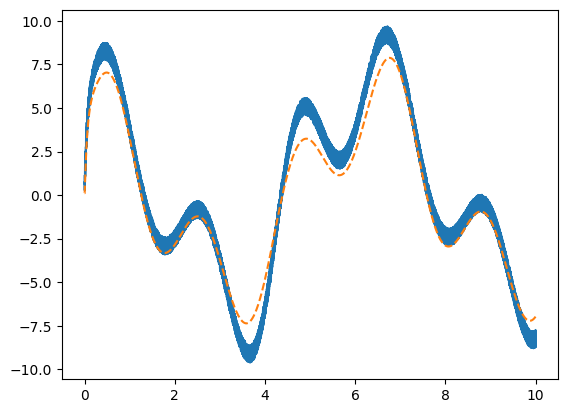

In [6]:
import matplotlib.pyplot as plt

plt.plot(t[:-1],y[0,0,:-1])
plt.plot(t[:-1],y_obs[0,0,:-1],'--')

plt.show()

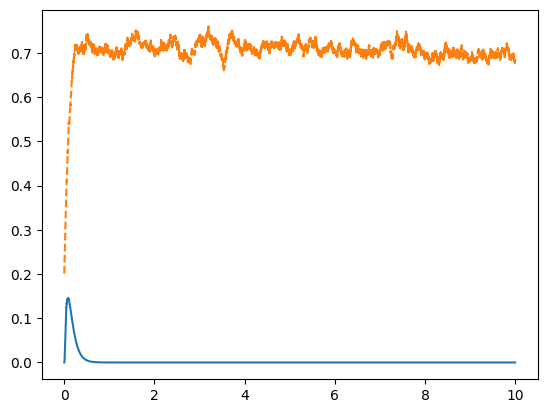

In [7]:
import matplotlib.pyplot as plt

plt.plot(t[:-1],x_obs[0,0,:-1])
plt.plot(t[:-1],x[0,0,:-1],'--')


plt.show()

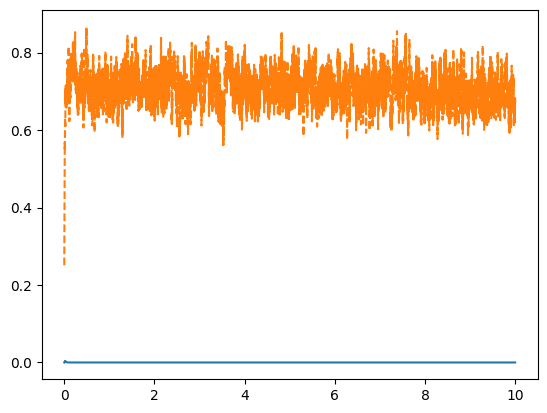

In [8]:
plt.plot(t[:-1],x_obs[1,0,:-1])
plt.plot(t[:-1],x[1,0,:-1],'--')

plt.show()

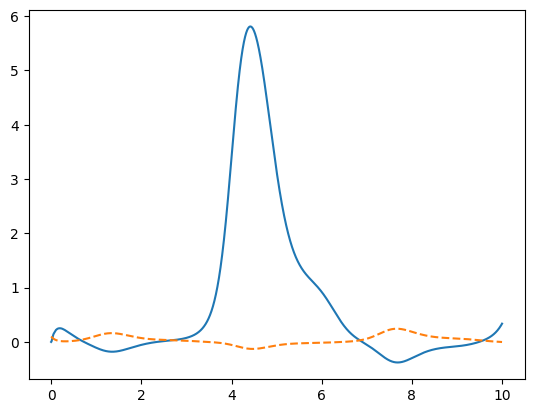

In [9]:
plt.plot(t[:-1],x_obs[2,0,:-1])
plt.plot(t[:-1],x[2,0,:-1],'--')
plt.show()

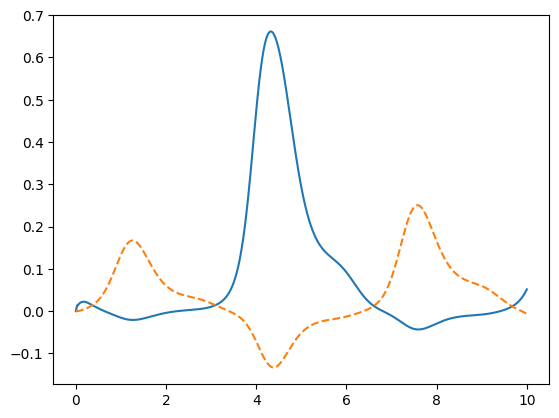

In [10]:
plt.plot(t[:-1],x_obs[3,0,:-1])
plt.plot(t[:-1],x[3,0,:-1],'--')

plt.show()

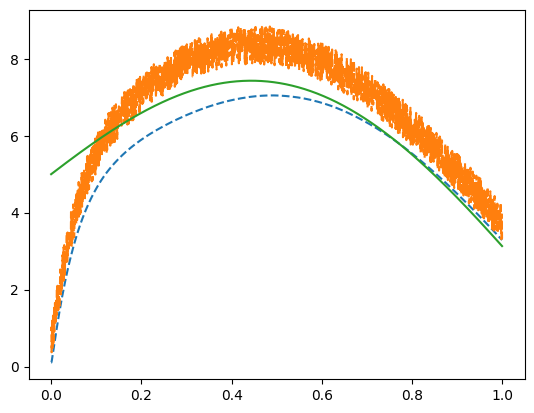

In [502]:
import matplotlib.pyplot as plt

plt.plot(t[:-1],y_obs[0,0,:-1],'--')
plt.plot(t[:-1],y[0,0,:-1],'--')
plt.plot(t[:-1],r[0,0,:-1])

plt.show()

In [42]:
import numpy as np

N = 20000
t = np.linspace(0,10,N)
dt = t[1] - t[0]
N_state = 5
N_output = 1
N_input = 1

## System parameter
ep = 0.037
epsilon = 0.0001
beta = 42
J_O2 = 6e-3
phi_in_O2 = 0.21
phi_in_H2 = 0.99
E0_cell = 1.2271
B_conc = 0.05
T_fc = 320.
A_fc = 0.1
rho0 = 0.006
rhoj = 4e-5
rhoT = 5e-5
V_act0 = 0.0178
C_DL = 4.8
z = 4
F = 96485.33
L = 5.9435e-5
L = 0.0013144869567532369
D = 2.2e-5

tau0 = 4*L**2/(D*np.pi)
tau1 = 4*L**2/(9*D*np.pi)
#tau0 = 0.1
#tau1 = 0.1/9
R = 8.3145

x = np.zeros([N_state,1,N])
#x0 = [0.21;0.21;0;0;0];
x[:,:,0] = np.array([0.201,0.251,0.10,0.0,0.0]).reshape(-1,1)
r = np.zeros([N_output,1,N])
rdot = np.zeros([N_output,1,N])
rddot = np.zeros([N_output,1,N])
y = np.zeros([N_output,1,N])

u = np.zeros([N_input,1,N])
e = np.zeros([N_input,1,N])
int_e = np.zeros([N_input,1,N])
dif_e = np.zeros([N_input,1,N])
u_eq = np.zeros([N_input,1,N])
u_S = np.zeros([N_input,1,N])
v_eq = np.zeros([N_input,1,N])
v_S = np.zeros([N_input,1,N])
s = np.zeros([N_input,1,N])
s2 = np.zeros([N_input,1,N])
#u_eq[0,0,0] = 100.
#u[0,0,0] = 10.

##
omega=2*np.pi*1
J_ss = 1000
J_amp = J_ss/2


### Controller Parametter
q = 5
p = 3

alpha = 0.9
b = 5.
m1 = 10.
m2 = 20.
delta = 1.
l = 0.0025


kd = 0.01
kp = 0.69
ki = 1.8

## Observer parameter
x_obs = np.zeros([N_state,1,N])
x_bar = np.zeros([N_state,1,N])
P_obs = np.random.rand(N_state,N_state,N)
#x_obs[:,:,0] = np.array([0.201,0.251,0.10,0.0,0.0]).reshape(-1,1)
Q_obs = np.array([[100000.]])
R_obs = np.array([[0.1]])
y_obs = np.zeros([N_output,1,N])


i = 0
u[0,0,i] = 0.1

def main(param):
    kp,kd,ki,b,m1,m2,delta = param
    for i in range(N-1):


        #u[0,0,i]=(J_ss+J_amp*np.sin(omega*t[i]))
        #r[0,0,i] = 0.95 + 0.05*np.sin(t[i])+0.02*np.sin(3*t[i])
        r[0,0,i] = + 5.*np.cos(t[i])+ 3.*np.sin(3*t[i])
        rdot[0,0,i] = -5.*np.sin(t[i]) + 9.*np.cos(3.*t[i])
        rddot[0,0,i] = 5.*np.cos(t[i]) - 27.*np.sin(3.*t[i])



        phi_O2_eff = 0.1512*(phi_in_O2) + (4/np.pi)*x[0,0,i] - (4/(3*np.pi))*x[1,0,i] - (0.1894*x[4,0,i]+(8/np.pi**2)*x[2,0,i])*(L/(z*F*D))


        y[0,0,i] = u[0,0,i] * (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff))  - 2*V_act0*np.arcsinh(x[4,0,i]/(2*J_O2)))
        vv = np.random.rand()
        y[0,0,i] = y[0,0,i] + vv



        ########## State Estimation ##########

        tauact = 2*V_act0*C_DL/(A_fc*np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2))/(4*J_O2**2 + x_obs[4,0,i]**2 + x_obs[4,0,i]**2 - u[0,0,i] * x_obs[4,0,i])
        Rohm = rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298)
        A_obs = np.array([[-(tau0**-1),0.,0.,0.,0.],
                   [0.,-(tau1**-1),0.,0.,0.],
                   [0.,0.,-(tau0**-1),0.,(tau1**-1)],
                   [0.,0.,0.,-(tau1**-1),(tau1**-1)],
                   [0.,0.,0.,0.,-(tauact**-1)]],dtype='f')
                  
        B_obs = np.array([[0],[0],[0],[0],[-np.sqrt(4*J_O2**2 + x_obs[4,0,i]**2)/(2.*V_act0*C_DL/A_fc)]],dtype='f')
        C_obs = u[0,0,i] *np.array([B_conc*4/(np.pi*phi_O2_eff),B_conc*4/(3*np.pi*phi_O2_eff),-B_conc*8*L/(z*F*D*np.pi*phi_O2_eff),0.,-B_conc*0.1894*L/(z*F*D*np.pi*phi_O2_eff)],dtype='f')
        D_obs = np.array([Rohm * A_fc - (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff))  - 2*V_act0*np.arcsinh(x[4,0,i]/(2*J_O2)))],dtype='f')
        Q_obshat = B_obs@Q_obs@B_obs.T
        R_obshat = R_obs + D_obs@Q_obs@D_obs.T
        L_obs = (P_obs[:,:,i]@C_obs.T).reshape(-1,1)@np.linalg.inv(R_obshat)
        G_obs = L_obs@(C_obs@P_obs[:,:,i]).reshape(1,-1)
        P_obsdot = A_obs@P_obs[:,:,i] + P_obs[:,:,i]@A_obs.T - P_obs[:,:,i]@G_obs@P_obs[:,:,i] + Q_obshat
        P_obs[:,:,i+1] = P_obs[:,:,i] + dt*P_obsdot
        
        phi_O2_eff_obs = 0.1512*(phi_in_O2) + (4/np.pi)*x_obs[0,0,i] - (4/(3*np.pi))*x_obs[1,0,i] - (0.1894*x_obs[4,0,i]+(8/np.pi**2)*x_obs[2,0,i])*(L/(z*F*D))
        y_obs[0,0,i] =  u[0,0,i] * (E0_cell - u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc -298))  + B_conc*np.log((phi_in_H2**2)*np.absolute(phi_O2_eff_obs))  - 2*V_act0*np.arcsinh(x_obs[4,0,i]/(2*J_O2)))
        x_bar[:,:,i] = x_obs[:,:,i] + L_obs@(y[:,:,i]-y_obs[0,0,i])

        
        x0_obsdot = (tau0**-1)*(phi_in_O2 - x_bar[0,0,i])
        x1_obsdot = (tau1**-1)*(phi_in_O2 - x_bar[1,0,i])
        x2_obsdot = (tau0**-1)*(x_bar[4,0,i] - x_bar[2,0,i])
        x3_obsdot = (tau1**-1)*(x_bar[4,0,i] - x_bar[3,0,i])
        x4_obsdot = np.sqrt(4*J_O2**2 + x_bar[4,0,i]**2)*(u[0,0,i]-x_bar[4,0,i])/(2*V_act0*C_DL/A_fc)
        
        x_obs[0,0,i+1] = x_obs[0,0,i] + dt*x0_obsdot
        x_obs[1,0,i+1] = x_obs[1,0,i] + dt*x1_obsdot
        x_obs[2,0,i+1] = x_obs[2,0,i] + dt*x2_obsdot
        x_obs[3,0,i+1] = x_obs[3,0,i] + dt*x3_obsdot
        x_obs[4,0,i+1] = x_obs[4,0,i] + dt*x4_obsdot
        
        
        #x_obsdot = A_obs@x_obs[:,:,i] + B_obs@u[:,:,i]
        #x_obs[:,:,i+1] = x_obs[:,:,i] + dt*x_obsdot

        
        
        ########## State Estimation ##########

        ###########
        ww = np.random.rand()
        x0dot = (tau0**-1)*(phi_in_O2 + ww - x[0,0,i])
        x1dot = (tau1**-1)*(phi_in_O2 + ww - x[1,0,i])
        x2dot = (tau0**-1)*(x[4,0,i] - x[2,0,i])
        x3dot = (tau1**-1)*(x[4,0,i] - x[3,0,i])
        x4dot = np.sqrt(4*J_O2**2 + x[4,0,i]**2)*(u[0,0,i]-x[4,0,i] + 0.1*np.random.rand())/(2*V_act0*C_DL/A_fc)
        #^^ tau = np.sqrt(4*J_O2**2 + u[0,0,i]**2)/(2*V_act0*C_DL/A_fc) -->dt  min 1/10 of lower

        x[0,0,i+1] = x[0,0,i] + dt*x0dot
        x[1,0,i+1] = x[1,0,i] + dt*x1dot
        x[2,0,i+1] = x[2,0,i] + dt*x2dot
        x[3,0,i+1] = x[3,0,i] + dt*x3dot
        x[4,0,i+1] = x[4,0,i] + dt*x4dot
        
        e[0,0,i] = -y_obs[0,0,i] + r[0,0,i] 
        if i>0:
            int_e[0,0,i] = int_e[0,0,i-1] + dt*(np.sign(e[0,0,i])*np.power(np.absolute(e[0,0,i]),q/p))
            dif_e[0,0,i] = e[0,0,i] - e[0,0,i-1]

        u[0,0,i+1] = kp*e[0,0,i] + ki*int_e[0,0,i] + kd*dif_e[0,0,i]

    
    BATCH_t = t
    BATCH_u = u[0,0,:]
    BATCH_S1 = s[0,0,:]
    BATCH_S2 = s2[0,0,:]
    return x, t,BATCH_t,BATCH_u,BATCH_S1,BATCH_S2

    
param = [kp,kd,ki,b,m1,m2,delta]
x1, t1,BATCH_t,BATCH_u,BATCH_S1,BATCH_S2 = main(param)
#- u[0,0,i]*A_fc*(rho0 + rhoj*u[0,0,i]*A_fc + rhoT*(T_fc - 298))
print(np.shape(x1))
print(np.shape(t1))
print(np.shape(BATCH_t))
print(np.shape(BATCH_u))
print(np.shape(BATCH_S1))
print(np.shape(BATCH_S2))


(5, 1, 20000)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)


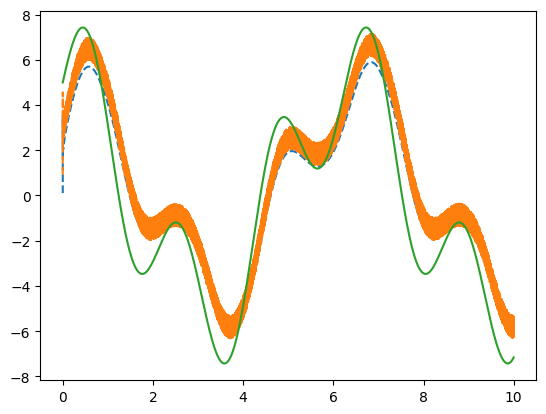

In [44]:
import matplotlib.pyplot as plt

plt.plot(t[:-1],y_obs[0,0,:-1],'--')
plt.plot(t[:-1],y[0,0,:-1],'--')
plt.plot(t[:-1],r[0,0,:-1])

plt.show()